‎

## Проект-исследование: задержка самолетов в США 2015 год

**Данные** - https://www.kaggle.com/usdot/flight-delays<br><br>
**Описание** - Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)<br>


**Задачи:**
- Найти аэропорт с минимальной задержкой вылета 
- Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
- Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)
- Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета  


‎

## Импорты

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import seaborn as sns

from tqdm import tqdm
import ipywidgets as widgets

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'


#pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
pd.options.mode.chained_assignment = None


from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, \
    mean_squared_error, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix

from sklearn.preprocessing import scale, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel


from sklearn.model_selection import cross_val_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import statsmodels.formula.api as sm

In [2]:
airlines = pd.read_csv('./datasets/airlines.csv', low_memory=False)
airports = pd.read_csv('./datasets/airports.csv', low_memory=False)
flights = pd.read_csv('./datasets/flights.csv', low_memory=False)

In [3]:
df = flights.copy()

In [4]:
RANDOM_STATE = 111

‎

## Осмотр данных

In [5]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [6]:
# Осмотрим датафрейм
info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
info = info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
info = info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


In [7]:
df.sample(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
151967,2015,1,10,6,OO,6268,N562SW,FAT,SFO,1737,1745.0,8.0,9.0,1754.0,63.0,50.0,35.0,158,1829.0,6.0,1840,1835.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3147630,2015,7,16,4,DL,1330,N332NB,DTW,CLT,1359,1354.0,-5.0,13.0,1407.0,108.0,96.0,79.0,500,1526.0,4.0,1547,1530.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5363681,2015,12,2,3,MQ,3403,N517MQ,XNA,DFW,1335,1331.0,-4.0,11.0,1342.0,83.0,66.0,48.0,280,1430.0,7.0,1458,1437.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5251018,2015,11,25,3,UA,1076,N73259,RSW,EWR,634,633.0,-1.0,13.0,646.0,174.0,166.0,145.0,1068,911.0,8.0,928,919.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
512939,2015,2,3,2,UA,1273,N69819,SFO,SEA,1935,1930.0,-5.0,16.0,1946.0,134.0,126.0,103.0,679,2129.0,7.0,2149,2136.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2963317,2015,7,5,7,WN,1778,N273WN,TUL,PHX,1735,1734.0,-1.0,7.0,1741.0,150.0,136.0,124.0,935,1745.0,5.0,1805,1750.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3692113,2015,8,17,1,WN,1683,N423WN,OMA,DEN,1915,1914.0,-1.0,7.0,1921.0,95.0,88.0,75.0,472,1936.0,6.0,1950,1942.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1157970,2015,3,16,1,OO,5375,N580SW,LAX,SBP,2257,2320.0,23.0,6.0,2326.0,62.0,45.0,34.0,156,2400.0,5.0,2359,5.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
313076,2015,1,21,3,OO,5504,N928EV,MFR,SFO,1357,1357.0,0.0,7.0,1404.0,75.0,69.0,56.0,329,1500.0,6.0,1512,1506.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3918523,2015,8,31,1,DL,1173,N357NB,ATL,BNA,1925,1925.0,0.0,9.0,1934.0,69.0,54.0,39.0,214,1913.0,6.0,1934,1919.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<div style="border:solid black 1px; padding: 20px"> <h2 style="color:solid black; margin-bottom:20px">Note</h2>

Осмотрели данные. Будем делать преобразования, чтобы сделать какие-либо выводы

‎

## Преобразования

### Даты

In [8]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [9]:
# сформатируем HHMM в datetime

def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400:
            chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    
# соединяем дату и время

def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
# соединяем две колонки 

def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400: #если вылета в 24 часа этого дня -> это уже новый день
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)




In [10]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = create_flight_time(df, 'DEPARTURE_TIME')

#df['SCHEDULED_TIME'] = create_flight_time(df, 'SCHEDULED_TIME')

df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)

#df['WHEELS_OFF'] = df['WHEELS_OFF'].apply(format_heure)
#df['WHEELS_ON'] = df['WHEELS_ON'].apply(format_heure)

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [11]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'WHEELS_OFF', 'WHEELS_ON']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY,WHEELS_OFF,WHEELS_ON
0,2015-01-01 00:05:00,04:30:00,2015-01-01 23:54:00,04:08:00,-11.0,-22.0,15.0,404.0
1,2015-01-01 00:10:00,07:50:00,2015-01-01 00:02:00,07:41:00,-8.0,-9.0,14.0,737.0
2,2015-01-01 00:20:00,08:06:00,2015-01-01 00:18:00,08:11:00,-2.0,5.0,34.0,800.0
3,2015-01-01 00:20:00,08:05:00,2015-01-01 00:15:00,07:56:00,-5.0,-9.0,30.0,748.0
4,2015-01-01 00:25:00,03:20:00,2015-01-01 00:24:00,02:59:00,-1.0,-21.0,35.0,254.0
5,2015-01-01 00:25:00,06:02:00,2015-01-01 00:20:00,06:10:00,-5.0,8.0,38.0,604.0


‎

### Пропуски

In [12]:
df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
DATE                         0
dtype: i

In [13]:
df['AIRLINE_DELAY'] = df['AIRLINE_DELAY'].fillna(0)
df['AIR_SYSTEM_DELAY'] = df['AIR_SYSTEM_DELAY'].fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].fillna(0)
df['WEATHER_DELAY'] = df['WEATHER_DELAY'].fillna(0)

<div style="border:solid black 1px; padding: 20px"> <h2 style="color:solid black; margin-bottom:20px">Note</h2>

Заполним нулями пропуски, так как там существуют значения только в том случае, если с полетом были проблемы (задержки, отмены)

In [14]:
df['CANCELLATION_REASON'].value_counts()

B    48851
A    25262
C    15749
D       22
Name: CANCELLATION_REASON, dtype: int64

In [15]:
df.loc[df['CANCELLATION_REASON'] == 'A', 'CANCELLATION_REASON'] = 1
df.loc[df['CANCELLATION_REASON'] == 'B', 'CANCELLATION_REASON'] = 2
df.loc[df['CANCELLATION_REASON'] == 'C', 'CANCELLATION_REASON'] = 3
df.loc[df['CANCELLATION_REASON'] == 'D', 'CANCELLATION_REASON'] = 4


df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna(0)

<div style="border:solid black 1px; padding: 20px"> <h2 style="color:solid black; margin-bottom:20px">Note</h2>

Вручную заменим категориальные значения на числовые

In [16]:
df.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
FLIGHT_NUMBER               0
TAIL_NUMBER             14721
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME          86153
DEPARTURE_DELAY         86153
TAXI_OUT                89047
WHEELS_OFF              89047
SCHEDULED_TIME              6
ELAPSED_TIME           105071
AIR_TIME               105071
DISTANCE                    0
WHEELS_ON               92513
TAXI_IN                 92513
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME            92513
ARRIVAL_DELAY          105071
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON         0
AIR_SYSTEM_DELAY            0
SECURITY_DELAY              0
AIRLINE_DELAY               0
LATE_AIRCRAFT_DELAY         0
WEATHER_DELAY               0
DATE                        0
dtype: int64

In [17]:
df = df.dropna(axis=0)

In [18]:
airports.loc[airports['IATA_CODE']=='ECP', 'LATITUDE'] = 30.3417
airports.loc[airports['IATA_CODE']=='ECP', 'LONGITUDE'] = -85.7973

airports.loc[airports['IATA_CODE']=='PBG', 'LATITUDE'] = 44.6521
airports.loc[airports['IATA_CODE']=='PBG', 'LONGITUDE'] = 73.4679

airports.loc[airports['IATA_CODE']=='UST', 'LATITUDE'] = 29.9544
airports.loc[airports['IATA_CODE']=='UST', 'LONGITUDE'] = 81.3429


<div style="border:solid black 1px; padding: 20px"> <h2 style="color:solid black; margin-bottom:20px">Note</h2>

Дропнем около 1.8% данных с пропусками

‎

## Подсчеты

### Задание: Найти аэропорт с минимальной задержкой вылета

In [19]:
pd.merge(df.groupby('ORIGIN_AIRPORT')\
    .agg({'DEPARTURE_DELAY':'mean'})\
    .reset_index()\
    .sort_values(by='DEPARTURE_DELAY')\
    .rename(columns = {'DEPARTURE_DELAY':'MEAN_DEPARTURE DELAY'})\
    , airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE').head(5)

,ORIGIN_AIRPORT,MEAN_DEPARTURE DELAY,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,YAK,-6.507692,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023
1,CNY,-6.058537,CNY,Canyonlands Field,Moab,UT,USA,38.75496,-109.75484
2,EKO,-3.771760,EKO,Elko Regional Airport,Elko,NV,USA,40.82493,-115.79170
3,VEL,-3.740000,VEL,Valdez Airport,Vernal,UT,USA,40.44090,-109.50992
4,CDV,-3.268405,CDV,Merle K. (Mudhole) Smith Airport,Cordova,AK,USA,60.49183,-145.47765


‎

### Задание: Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

In [20]:
df['IS_DELAYED_ON_DEPARTURE'] = df.loc[df['DEPARTURE_DELAY'] <= 0, 'IS_DELAYED_ON_DEPARTURE']=0
df.loc[df['DEPARTURE_DELAY'] > 0, 'IS_DELAYED_ON_DEPARTURE']=1

df['IS_DELAYED_ON_ARRIVAL'] = df.loc[df['ARRIVAL_DELAY'] <= 0, 'IS_DELAYED_ON_ARRIVAL']=0
df.loc[df['ARRIVAL_DELAY'] > 0, 'IS_DELAYED_ON_ARRIVAL']=1

In [21]:
lax_log = df[df['DESTINATION_AIRPORT'] == 'LAX'].copy()

lax_log = pd.merge(
    lax_log.groupby('AIRLINE').agg({'IS_DELAYED_ON_DEPARTURE':'sum'}).reset_index()\
    .rename(columns = {'IS_DELAYED_ON_DEPARTURE':'DELAYED_FLIGHTS'}),
    lax_log.groupby('AIRLINE').agg({'IS_DELAYED_ON_DEPARTURE':'count'}).reset_index()\
    .rename(columns = {'IS_DELAYED_ON_DEPARTURE':'NUM_OF_FLIGHTS'}))

lax_log['% OF DELAYED FLIGHTS'] = lax_log['DELAYED_FLIGHTS'] / lax_log['NUM_OF_FLIGHTS']

lax_log = lax_log.sort_values(by='% OF DELAYED FLIGHTS')

pd.merge(lax_log, airlines, left_on='AIRLINE', right_on='IATA_CODE', suffixes=['_CODE', '_NAME'])

,AIRLINE_CODE,DELAYED_FLIGHTS,NUM_OF_FLIGHTS,% OF DELAYED FLIGHTS,IATA_CODE,AIRLINE_NAME
0,AS,2250,8057,0.279260,AS,Alaska Airlines Inc.
1,HA,482,1549,0.311168,HA,Hawaiian Airlines Inc.
2,OO,11572,36112,0.320447,OO,Skywest Airlines Inc.
3,AA,12196,32344,0.377071,AA,American Airlines Inc.
4,B6,1528,4044,0.377844,B6,JetBlue Airways
5,VX,4430,11693,0.378859,VX,Virgin America
6,DL,10439,25076,0.416294,DL,Delta Air Lines Inc.
7,US,1549,3656,0.423687,US,US Airways Inc.
8,F9,620,1378,0.449927,F9,Frontier Airlines Inc.
9,MQ,80,162,0.493827,MQ,American Eagle Airlines Inc.


‎

### Задание: Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [22]:
pd.merge(
    df.groupby('ORIGIN_AIRPORT')\
        .agg({'TAXI_OUT':'mean'}).reset_index()\
        .sort_values(by='TAXI_OUT', ascending=False)\
        .rename(columns = {'TAXI_OUT':'TAXI_OUT_MEAN'}),
    airports,
    left_on='ORIGIN_AIRPORT', right_on='IATA_CODE'
).head()


,ORIGIN_AIRPORT,TAXI_OUT_MEAN,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,JFK,26.995582,JFK,John F. Kennedy International Airport (New York International Airport),New York,NY,USA,40.63975,-73.77893
1,LGA,26.711306,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
2,ITH,22.533333,ITH,Ithaca Tompkins Regional Airport,Ithaca,NY,USA,42.49103,-76.45844
3,PHL,21.691279,PHL,Philadelphia International Airport,Philadelphia,PA,USA,39.87195,-75.24114
4,ISN,21.014925,ISN,Sloulin Field International Airport,Williston,ND,USA,48.17794,-103.64235


‎

### Задание: Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

#### Матрица корреляции

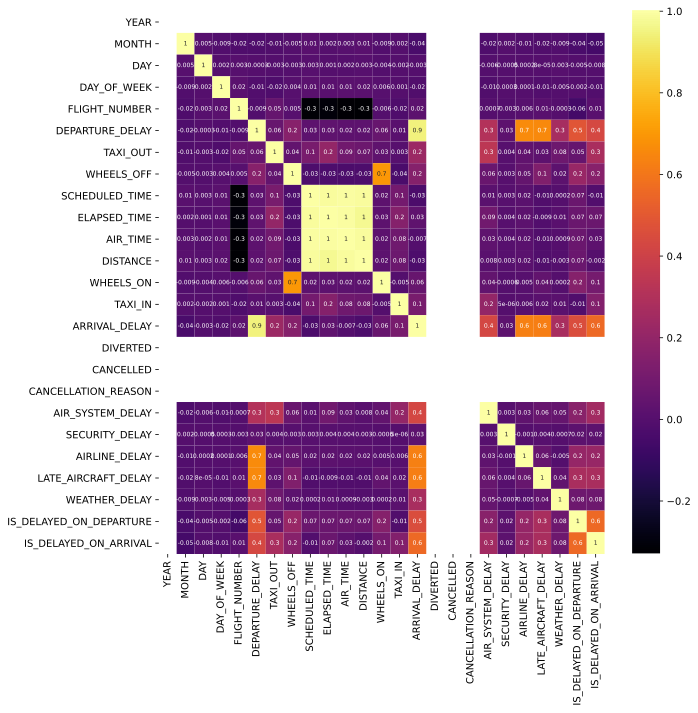

In [23]:
# Dataframe correlation
del_corr = df.corr()

# Draw the figure
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap
sns.heatmap(del_corr,annot=True,cmap='inferno', fmt='.1g', annot_kws={"fontsize":6})
plt.show()

<div style="border:solid black 1px; padding: 20px"> <h2 style="color:solid black; margin-bottom:20px">Note</h2>
    
    Высокая корреляция: больше 0.6
        DEPARTURE_DELAY и
        ARRIVAL_DELAY
        LATE_AIRCRAFT_DELAY
        AIRLINE_DELAY
    
        ARRIVAL_DELAY и
        DEPARTURE_DELAY
        LATE_AIRCRAFT_DELAY
        AIRLINE_DELAY
    Средняя корреляция: больше 0.2, но меньше 0.6
        ARRIVAL_DELAY и
        AIR_SYSTEM_DELAY
        WEATHER_DELAY
    
        DEPARTURE_DELAY и
        AIR_SYSTEM_DELAY
        WEATHER_DELAY
    
        TAXI_OUT и
        AIR_SYSTEM_DELAY
        ELAPSED_TIME

‎

#### Линейная регрессия

In [24]:
df_grouped = df.groupby(['DATE','DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].sum().reset_index()
df_grouped['DATE'] = pd.to_datetime(df_grouped['DATE'])

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.DATE.dt.year
    data['month'] = data.DATE.dt.month
    data['day'] = data.DATE.dt.day
    data['dayofweek'] = data.DATE.dt.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)

In [26]:
where_to_go = []
for dest in df_grouped.DESTINATION_AIRPORT.unique():
    temp = df_grouped[df_grouped.DESTINATION_AIRPORT==dest][['DATE','ARRIVAL_DELAY']]
    temp.columns = ['DATE','ARRIVAL_DELAY']
    temp = pd.DataFrame(temp)
    
    try:
    
        make_features(temp,21,7)
        temp.dropna(inplace=True)
        temp.set_index('DATE',inplace=True)
           
        X_train, X_test, y_train, y_test = train_test_split(temp.drop('ARRIVAL_DELAY', axis=1),
                                                          temp.ARRIVAL_DELAY, shuffle=False, 
                                                          test_size=0.25)

        model_lr = LinearRegression()
        model_lr.fit(X_train,y_train)

        y_predicted_lr = model_lr.predict(X_test)
        where_to_go.append([dest,y_test.mean(),np.sqrt(mean_squared_error(y_test, y_predicted_lr))])

    except:
        pass
        

In [27]:
where_to_go = pd.DataFrame(where_to_go)
where_to_go.columns = ['DESTINATION_AIRPORT','MEAN_ARRIVAL_DELAY_IN_PAST','RMSE']


In [28]:

start_airport = np.random.choice(flights['ORIGIN_AIRPORT'].unique()) 
where_to_go_from_start_airport = flights[flights.ORIGIN_AIRPORT==start_airport]['DESTINATION_AIRPORT'].unique()

where_to_go_from_start_airport = pd.DataFrame(where_to_go_from_start_airport)
where_to_go_from_start_airport.columns = ['DESTINATION_AIRPORT']

top3 = where_to_go_from_start_airport\
    .merge(where_to_go,on='DESTINATION_AIRPORT',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_IN_PAST'],ascending=[True, True])\
    .head(3)

print('Лучшие направления с аэропорта',start_airport)
print('')
print(top3)


Лучшие направления с аэропорта LNK

  DESTINATION_AIRPORT  MEAN_ARRIVAL_DELAY_IN_PAST          RMSE
3                 MSP                  547.721519   2985.553102
0                 DEN                 1733.911392   7198.405552
2                 ATL                 1604.569620  13304.649765


<div style="border:solid black 1px; padding: 20px"> <h2 style="color:solid black; margin-bottom:20px">Note</h2>
    
Сначала попробовали построить модель линейной регрессии используя всевозможные фичи. Но так как время задержки из вылета (DEPARTURE_DELAY) имел существенный вес в модели --> было принято решение применить метод временных рядов, построили модель, которая выдает три наиболее оптимальных аэропорта для прибытия, исходя из выбранного аэропорта вылета.

‎